# Explore Trends in Data

- Trends in GWA's

In [95]:
%reset -f

In [96]:
%reload_ext autoreload
%autoreload 2

In [97]:
import os
import random
import re
import sys
from pathlib import Path

import folium
import geemap
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from google.cloud import storage as gcs

In [98]:
# Google earth engine
import ee

try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

In [99]:
PROJ = Path(os.path.realpath("."))
ROOT = PROJ.parents[1]
DATA = ROOT / "data/"

In [100]:
sys.path.append(str(PROJ))
sys.path.append(str(ROOT / "src/"))
from gee_utils import *
from process_viirs import *

In [101]:
sns.set_theme(style="whitegrid", font_scale=1.3)

# Inputs

In [102]:
cntry_selected = "Colombia"
cntry_selected_abbr = "COL"
month = "2021-05"
vcm_type = "vcmsl"
selected_admin_level = 2
scaleFactor = 500

# Preview VIIRS Overall

In [86]:
def get_days_in_month(monthstr):
    import calendar

    year, month = monthstr.split("-")
    return calendar.monthrange(int(year), int(month))[1]

In [87]:
# Get country centroid
def get_country_centroid(iso):
    # Read country boundaries and get a rough centroid
    import warnings

    gdf_centroid = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
    gdf_centroid = gdf_centroid[gdf_centroid.iso_a3 == iso]
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        centroid_point = gdf_centroid.centroid.iloc[0]
    return [centroid_point.y, centroid_point.x]

In [88]:
# Get nighttime lights image for selected month
opacitylevel = 0.6
last_day = get_days_in_month(month)
viirs_vcmsl_month = (
    ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG")
    .filterDate(f"{month}-01", f"{month}-{last_day}")
    .select("avg_rad")
    .first()
)
viirs_vcm_month = (
    ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMCFG")
    .filterDate(f"{month}-01", f"{month}-{last_day}")
    .select("avg_rad")
    .first()
)
viirs_cf_cvg_month = (
    ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMCFG")
    .filterDate(f"{month}-01", f"{month}-{last_day}")
    .select("cf_cvg")
    .first()
)
gmap = geemap.Map(
    add_google_map=False, center=get_country_centroid(cntry_selected_abbr), zoom=5
)
# gmap.addLayer(
#     viirs_cf_cvg_month,
#     vis_params={},
#     name="VIIRS Monthly (Cloud-Free Coverage)",
#     opacity=opacitylevel,
# )
gmap.addLayer(
    viirs_vcmsl_month,
    vis_params={},
    name="VIIRS Monthly (Stray Light Corrected)",
    opacity=opacitylevel,
)
# gmap.addLayer(
#     viirs_vcm_month,
#     vis_params={},
#     name="VIIRS Monthly (No Correction)",
#     opacity=opacitylevel,
# )
gmap.addLayerControl()
gmap

Map(center=[3.927213862709704, -73.07773208697478], controls=(WidgetControl(options=['position', 'transparent_…

# Load and Process GEE

In [89]:
# Uncomment to set up GADM data without the geometry to save space
# prepare_gadm_without_geometry()

## Preview zonal stats

In [90]:
# Load administrative boundaries
country_boundaries_ee, admin_boundaries_ee = load_admin_boundaries(
    cntry_selected_abbr, selected_admin_level
)

In [91]:
# Calculate zonal stats
scaleFactor = 500

admin_radiance = viirs_vcm_month.reduceRegions(
    reducer=ee.Reducer.mean(), collection=admin_boundaries_ee, scale=scaleFactor
)

In [92]:
# Convert to raster
admin_radiance_ee = ee.FeatureCollection(admin_radiance)

radiance_img = admin_radiance_ee.reduceToImage(
    properties=["mean"], reducer=ee.Reducer.first()
)

In [93]:
admin_radiance_ee.aggregate_stats("mean").getInfo()

{'max': 42.67048128350815,
 'mean': 0.8091628535140705,
 'min': 0.0017050788920875955,
 'sample_sd': 2.0289130825043964,
 'sample_var': 4.116488296357492,
 'sum': 861.758438992485,
 'sum_sq': 5077.246464859361,
 'total_count': 1065,
 'total_sd': 2.0279603174448124,
 'total_var': 4.112623049130865,
 'valid_count': 1065,
 'weight_sum': 1065,
 'weighted_sum': 861.758438992485}

In [94]:
country_geemap = geemap.Map(add_google_map=False)
country_geemap.centerObject(admin_boundaries_ee, zoom=6)
viz_params = {
    "min": 0,
    "max": 6,
    "palette": ["2C105C", "711F81", "B63679", "EE605E", "FDAE78", "FCFDBF"],
}
country_geemap.addLayer(admin_radiance_ee, {}, "Area boundaries", opacity=0.5)
country_geemap.addLayer(
    radiance_img, viz_params, f"VIIRS {month} avg radiance by prefecture", opacity=0.6
)
country_geemap.addLayerControl()
country_geemap

Map(center=[3.8922579649048292, -73.08271405141382], controls=(WidgetControl(options=['position', 'transparent…

## Time series

In [23]:
# Load administrative boundaries
country_boundaries_ee, admin_boundaries_ee = load_admin_boundaries(
    cntry_selected_abbr, selected_admin_level
)

In [103]:
viirs_img = (
    ee.ImageCollection(f"NOAA/VIIRS/DNB/MONTHLY_V1/{vcm_type.upper()}CFG")
    .filterDate(f"{month}-01", f"{month}-03")
    .select("avg_rad")
)

In [104]:
viirs_img

In [105]:
type(viirs_img) = ee.imagecollection.ImageCollection

ee.imagecollection.ImageCollection

In [106]:
isinstance(viirs_img, ee.imagecollection.ImageCollection)

True

In [21]:
# map these functions to our image collection
reduced_admin, dates = get_reduced_imagecollection(
    viirs_img, fc_boundaries=admin_boundaries_ee, scaleFactor=500, grouped=False
)

In [18]:
# Extract results
results_df = extract_reduction_results(
    reduced_admin, dates, id_cols=[f"GID_{selected_admin_level}"]
)

In [19]:
results_df.head()

,GID_1,mean,sum,median,stdDev,count,min,max,date
0,COL.29_1,0.407963,38552.209083,0.219471,1.893293,95517,-0.41,77.970001,2021-05-01
1,COL.30_1,1.166626,103589.335086,0.303244,6.249671,90359,-0.26,196.100006,2021-05-01
2,COL.2_1,0.334036,85573.861607,0.173424,1.787724,258520,-0.53,82.400002,2021-05-01
3,COL.4_1,3.459514,62571.971639,0.676737,11.261742,18466,0.00,118.940002,2021-05-01
4,COL.5_1,0.669401,70985.488904,0.320744,5.623440,107689,0.00,808.369995,2021-05-01


In [67]:
results_df.to_parquet(
    PROJ
    / f"tables/{vcm_type}_{cntry_selected_abbr}_level{selected_admin_level}.parquet",
    index=False,
)

## Time series by land cover type

In [379]:
# Load administrative boundaries
country_boundaries_ee, admin_boundaries_ee = load_admin_boundaries(
    cntry_selected_abbr, 0
)

In [380]:
# VIIRS
viirs_img = (
    ee.ImageCollection(f"NOAA/VIIRS/DNB/MONTHLY_V1/{vcm_type.upper()}CFG")
    #     .filterDate(f"{month}-01", f"{month}-25")
    .select("avg_rad")
)

In [381]:
# Add MODIS
viirs_with_modis = viirs_img.map(add_modis_to_viirs_img)

In [382]:
# Reduce
reduced_admin_lc = get_reduced_imagecollection(
    viirs_with_modis,
    fc_boundaries=admin_boundaries_ee,
    scaleFactor=500,
    grouped=True,
    grouping_band_index=1,
    group_name="land_cover",
)

In [383]:
# Extract results
results_df = extract_reduction_results_grouped(
    reduced_admin_lc, id_cols=[f"GID_0"], grouping_cols=["land_cover"]
)
results_df.head()

,date,GID_0,count,land_cover,max,mean,median,min,stdDev,sum
0,2014-01-01,ZAF,17778,1.0,341.722229,0.573814,0.195964,-0.447147,6.501037,8.621153e+03
0,2014-01-01,ZAF,5597943,2.0,3099.495117,0.382252,0.256959,-0.313446,3.580866,2.136908e+06
1,2014-02-01,ZAF,17778,1.0,567.222595,0.622708,0.239680,-0.202694,8.343397,9.355744e+03
1,2014-02-01,ZAF,5597943,2.0,4719.804688,0.373039,0.313675,-0.253538,5.874264,2.085406e+06
2,2014-03-01,ZAF,17778,1.0,518.562073,0.662481,0.257960,-0.061114,8.328599,9.953311e+03


In [384]:
results_df.to_parquet(
    PROJ / f"tables/{vcm_type}_{cntry_selected_abbr}_by_landcover.parquet",
    index=False,
)

## Time series after thresholding

In [59]:
# Get VIIRS results
results_df = get_time_series_viirs_gadm(
    cntry_selected_abbr, selected_admin_level, vcm_type, scaleFactor
)
results_df.head()

,date,GID_0,mean,sum,median,stdDev,count,min,max
0,2014-01-01,USA,1.372669,1.056255e+07,1.311930,2.613705,7716248,0.787872,1705.675049
1,2014-01-01,USA,4.835530,6.959047e+06,4.039204,18.663671,1444595,0.787872,10867.438477
2,2014-01-01,USA,9.122901,5.667119e+06,3.937108,27.258275,631764,0.787873,6435.785645
3,2014-01-01,USA,6.765771,6.580716e+06,2.141134,17.075432,987493,0.787874,1269.789917
4,2014-02-01,USA,1.251123,9.615289e+06,1.182458,2.558158,7705875,0.582574,790.785767


In [55]:
# Get VIIRS results - export to gcs
results = get_time_series_viirs_gadm(
    cntry_selected_abbr,
    0,
    vcm_type,
    scaleFactor,
    export_to_gcs=f"VIIRS_{vcm_type}_{cntry_selected_abbr}_level{selected_admin_level}_thresholded",
    gcs_bucket="earth_engine_aggregations"
)

In [60]:
results_df.to_parquet(
    PROJ
    / f"tables/{vcm_type}_{cntry_selected_abbr}_level{selected_admin_level}_thresholded.parquet",
    index=False,
)

In [61]:
results_df.to_csv(
    PROJ
    / f"tables/{vcm_type}_{cntry_selected_abbr}_level{selected_admin_level}_thresholded.csv",
    index=False,
)

## Run for all countries

In [54]:
cntry_list = pd.read_parquet(
    DATA / f"intermediate/gadm_without_geometry/gadm36_0.parquet"
)
cntry_list.head(2)

,GID_0,NAME_0
0,ABW,Aruba
1,AFG,Afghanistan


In [55]:
def initialize_gcs():
    client = gcs.Client()
    bucket = client.get_bucket("earth_engine_aggregations")
    return bucket

In [56]:
def check_if_file_exists(filename, bucket):
    return gcs.Blob(bucket=bucket, name=filename).exists()

In [57]:
bucket = initialize_gcs()

In [58]:
# Run for all countries
results_dict = {}
# for admin_level in [0, 1, 2]:
admin_level = 0
for i, cntry_row in cntry_list.iterrows():
    # Set outfile name
    outfile = f"VIIRS_{vcm_type}_{cntry_row.GID_0}_level{admin_level}_thresholded"
    # Check if file exists
    if not check_if_file_exists(f"{outfile}.csv", bucket):
        # Get VIIRS results - export to drive
        results = get_time_series_viirs_gadm(
            cntry_selected_abbr=cntry_row.GID_0,
            selected_admin_level=admin_level,
            vcm_type=vcm_type,
            scaleFactor=scaleFactor,
            export_to_gcs=outfile,
            gcs_bucket="earth_engine_aggregations"
        )
        # Put result in dict
        results_dict[cntry_row.GID_0] = results

In [28]:
results_dict["AFG"]

<Task TZ26EJ73ULNM7U2IQ2HJLT6L EXPORT_FEATURES: VIIRS_vcmsl_AFG_level2_thresholded (UNSUBMITTED)>

## Time series after thresholding - city level

In [47]:
# Get VIIRS results
results_df = get_time_series_viirs_ghs(
    cntry_selected_abbr, vcm_type, scaleFactor
)
results_df.head()

,date,ghs_id,mean,sum,median,stdDev,count,min,max
0,2014-01-01,419,21.607866,882.363580,15.811034,15.380101,53,0.597085,57.041435
1,2014-01-01,461,11.175529,125.954790,9.024038,8.227171,13,0.908239,32.407982
2,2014-01-01,488,12.611813,560.013936,12.983452,7.047405,66,0.876056,32.524792
3,2014-01-01,492,21.696950,2427.335633,21.255346,10.726929,138,3.663409,43.029499
4,2014-01-01,495,1.973272,31.200907,1.591815,1.162229,22,0.474702,4.198264


In [48]:
results_df.to_parquet(
    PROJ / f"tables/{vcm_type}_{cntry_selected_abbr}_ghs_thresholded.parquet",
    index=False,
)

In [49]:
results_df.to_csv(
    PROJ / f"tables/{vcm_type}_{cntry_selected_abbr}_ghs_thresholded.csv",
    index=False,
)

# Testing

In [ ]:
# Load administrative boundaries
country_boundaries_ee, admin_boundaries_ee = load_admin_boundaries(
    cntry_selected_abbr, selected_admin_level
)

In [ ]:
viirs_img = (
    ee.ImageCollection(f"NOAA/VIIRS/DNB/MONTHLY_V1/{vcm_type.upper()}CFG")
    .filterDate(f"{month}-01", f"{month}-03")
    .select("avg_rad")
)

In [ ]:
# map these functions to our image collection
reduced_admin = get_reduced_imagecollection(
    viirs_img, fc_boundaries=admin_boundaries_ee, scaleFactor=500, grouped=False
)

In [ ]:
# Extract results
id_cols = ["GID_0"]
reduced_fc = reduced_admin

# Convert data into EE lists
stats_list = [
    "mean",
    "sum",
    "median",
    "stdDev",
    "count",
    "min",
    "max",
]
id_cols = ["date"] + id_cols
key_cols = id_cols + stats_list

areas_list = reduced_fc.reduceColumns(
    ee.Reducer.toList(len(key_cols)), key_cols
).values()

In [ ]:
# Prepare and start export task
export_task = ee.batch.Export.table.toDrive(
    collection=reduced_fc,
    description=f"VIIRS - {cntry_selected_abbr} - level {selected_admin_level} - {vcm_type}",
    folder="earth_engine",
    fileFormat="CSV",
    selectors=key_cols,
)
export_task.start()

In [ ]:
results_df.head()

,GID_1,mean,sum,median,stdDev,count,min,max,date
0,COL.29_1,0.407963,38552.209083,0.219471,1.893293,95517,-0.41,77.970001,2021-05-01
1,COL.30_1,1.166626,103589.335086,0.303244,6.249671,90359,-0.26,196.100006,2021-05-01
2,COL.2_1,0.334036,85573.861607,0.173424,1.787724,258520,-0.53,82.400002,2021-05-01
3,COL.4_1,3.459514,62571.971639,0.676737,11.261742,18466,0.00,118.940002,2021-05-01
4,COL.5_1,0.669401,70985.488904,0.320744,5.623440,107689,0.00,808.369995,2021-05-01


# Quick exploration

## Inputs

In [22]:
vcm_type = "vcmsl"
cntry_selected_abbr = "COL"
selected_admin_level = 1

## Plotting funs

In [23]:
def get_distinct_colors():
    # Colors from https://sashamaps.net/docs/resources/20-colors/
    distinct_colors = [
        "#e6194B",
        "#3cb44b",
        "#ffe119",
        "#4363d8",
        "#f58231",
        "#911eb4",
        "#42d4f4",
        "#f032e6",
        "#bfef45",
        "#fabed4",
        "#469990",
        "#dcbeff",
        "#9A6324",
        "#fffac8",
        "#800000",
        "#aaffc3",
        "#808000",
        "#ffd8b1",
        "#000075",
        "#a9a9a9",
    ]
    return distinct_colors

In [24]:
def plot_ntl_line(
    df,
    stat="sum",
    markersize=4,
    hue="uc_name",
    plot_scatter=True,
    figsize=(12, 8),
    **kwargs
):
    f, ax = plt.subplots(figsize=figsize)
    distinct_colors = get_distinct_colors()
    x = "date"
    y = stat

    for color, region in zip(distinct_colors, df[hue].unique()):
        df_region = df[df[hue] == region].sort_values(x)
        if plot_scatter:
            ax.scatter(df_region[x], df_region[y], c=color, s=markersize)
        ax.plot(df_region[x], df_region[y], c=color, label=region)
        ax.set_ylabel("Radiance (nW/cm2/sr)")
        ax.legend()
    return f, ax

In [25]:
def plot_ntl_smoothed(
    df, stat="sum", markersize=3, hue="uc_name", plot_scatter=True, figsize=(12, 8)
):
    from statsmodels.nonparametric.smoothers_lowess import lowess
    import datetime

    # Calculate smoothing and plot
    y = stat
    x = "date"
    label = hue
    distinct_colors = get_distinct_colors()

    f, ax = plt.subplots(figsize=figsize)

    get_unix_time = lambda dates: (dates - pd.Timestamp("1970-01-01")) // pd.Timedelta(
        "1s"
    )

    for color, region in zip(distinct_colors, df[label].unique()):
        df_region = df[df[label] == region]
        smoothed = lowess(
            df_region[y],
            get_unix_time(df_region[x]),
            frac=0.2,
            it=3,
            return_sorted=True,
        )
        smoothedx, smoothedy = smoothed[:, 0], smoothed[:, 1]
        smoothedx = pd.to_datetime(smoothedx, unit="s")
        if plot_scatter:
            ax.scatter(df_region[x], df_region[y], c=color, alpha=0.6, s=3)
        ax.plot(smoothedx, smoothedy, c=color, label=region)
        ax.set_ylabel("Radiance (nW/cm2/sr)")
        ax.legend()
    return f, ax

In [84]:
def plot_heatmap_geo(
    geo_plot_df, cntry_selected_abbr, statcol="sum", opacity=1, figsize=(24, 20)
):
    # Plot
    f, ax = plt.subplots(figsize=(24, 20))
    # Convert to 3857 for basemap
    ax = geo_plot_df.to_crs(epsg=3857).plot(
        column=statcol, ax=ax, edgecolor="k", legend=True, alpha=opacity
    )
    # Add country boundaries
    gdf_mask = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
    ax = (
        gdf_mask[gdf_mask.iso_a3 == cntry_selected_abbr]
        .to_crs(epsg=3857)
        .plot(facecolor="none", edgecolor="black", ax=ax)
    )
    ax.axis("off")
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
    return f, ax

## GADM

In [67]:
results_df = pd.read_parquet(
    PROJ
    / f"tables/{vcm_type}_{cntry_selected_abbr}_level{selected_admin_level}_thresholded.parquet"
)

In [68]:
# Prepare visualization data
def prep_viz_data(df, selected_admin_level, topn=5, selected_regions=None):
    # Assign names
    gadm_names = pd.read_parquet(
        ROOT
        / f"data/intermediate/gadm_without_geometry/gadm36_{selected_admin_level}.parquet"
    )
    df = df.merge(
        gadm_names[[f"GID_{selected_admin_level}", f"NAME_{selected_admin_level}"]],
        on=f"GID_{selected_admin_level}",
    )
    # Select some regions
    if selected_regions is None:
        selected_regions = (
            df.groupby([f"NAME_{selected_admin_level}"])["mean"]
            .sum()
            .nlargest(topn)
            .index.tolist()
        )
    # Filter data to selected
    df = df[df[f"NAME_{selected_admin_level}"].isin(selected_regions)].copy()
    return df

In [69]:
viz_df = prep_viz_data(
    results_df,
    selected_admin_level=selected_admin_level,
    #     selected_regions=["Caquetá", "Putumayo", "Guaviare"],
)
viz_df.head()

,date,GID_1,mean,sum,median,stdDev,count,min,max,NAME_1
264,2014-01-01,COL.4_1,3.923454,55215.582310,0.285749,13.619179,14328,0.073821,131.048767,Atlántico
265,2014-02-01,COL.4_1,3.489354,55209.179428,0.244021,11.804116,16125,0.113018,127.341309,Atlántico
266,2014-03-01,COL.4_1,3.282152,51205.258922,0.229206,11.148384,15880,0.099597,110.995590,Atlántico
267,2014-04-01,COL.4_1,3.019289,51929.269920,0.308937,10.007047,17533,0.179494,95.983421,Atlántico
268,2014-05-01,COL.4_1,2.630667,47549.722031,0.159915,10.181843,18453,-0.088008,112.136147,Atlántico


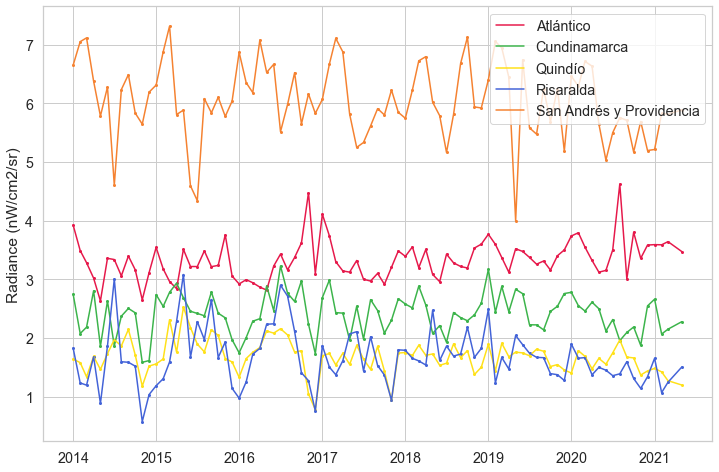

In [70]:
f, ax = plot_ntl_line(viz_df, stat="mean", hue=f"NAME_{selected_admin_level}")
f.savefig(
    PROJ / f"figs/{cntry_selected_abbr}_{vcm_type}_gadm_{selected_admin_level}.png",
    bbox_inches="tight",
)

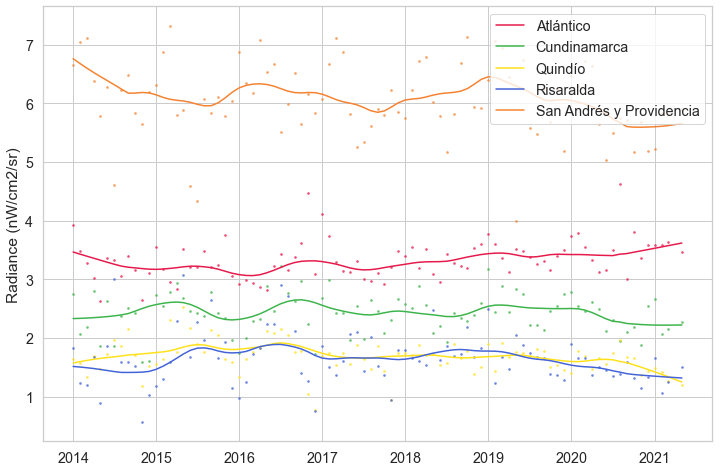

In [71]:
f, ax = plot_ntl_smoothed(viz_df, stat="mean", hue=f"NAME_{selected_admin_level}")
f.savefig(
    PROJ
    / f"figs/{cntry_selected_abbr}_{vcm_type}_gadm_{selected_admin_level}_smoothed.png",
    bbox_inches="tight",
)

### Admin boundaries

In [92]:
month = "2021-01-01"
year_selected = pd.to_datetime(month).year

In [73]:
# Prepare GADM shapefile
gdf_mask = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
gadm = gpd.read_file(
    DATA / f"raw/shapefiles/gadm/gadm36_{selected_admin_level}.shp",
    mask=gdf_mask[gdf_mask.iso_a3 == cntry_selected_abbr],
)
gadm.head()

,GID_0,NAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,geometry
0,BRA,Brazil,BRA.4_1,Amazonas,Amazone,None,Estado,State,None,BR.AM,"POLYGON ((-58.13699 -7.35614, -58.13682 -7.356..."
1,COL,Colombia,COL.1_1,Amazonas,None,None,Comisaría,Commissiary,None,CO.AM,"MULTIPOLYGON (((-69.43138 -1.07847, -69.42712 ..."
2,COL,Colombia,COL.2_1,Antioquia,None,None,Departamento,Department,None,CO.AN,"MULTIPOLYGON (((-76.99986 8.99986, -77.00014 8..."
3,COL,Colombia,COL.3_1,Arauca,None,None,Intendencia,Intendancy,None,CO.AR,"POLYGON ((-69.92316 6.05792, -69.92910 6.06720..."
4,COL,Colombia,COL.4_1,Atlántico,None,None,Departamento,Department,None,CO.AT,"POLYGON ((-74.88160 10.34100, -74.88670 10.329..."


In [94]:
# Prepare geoplot df
geo_plot_df = results_df.copy()
geo_plot_df["year"] = geo_plot_df.date.dt.year
geo_plot_df = (
    geo_plot_df.groupby([f"GID_{selected_admin_level}", "year"])[
        ["mean", "sum", "median"]
    ]
    .mean()
    .reset_index()
)
geo_plot_df = geo_plot_df[geo_plot_df.year == year_selected]
geo_plot_df = gadm.merge(
    geo_plot_df,
    on=f"GID_{selected_admin_level}",
)

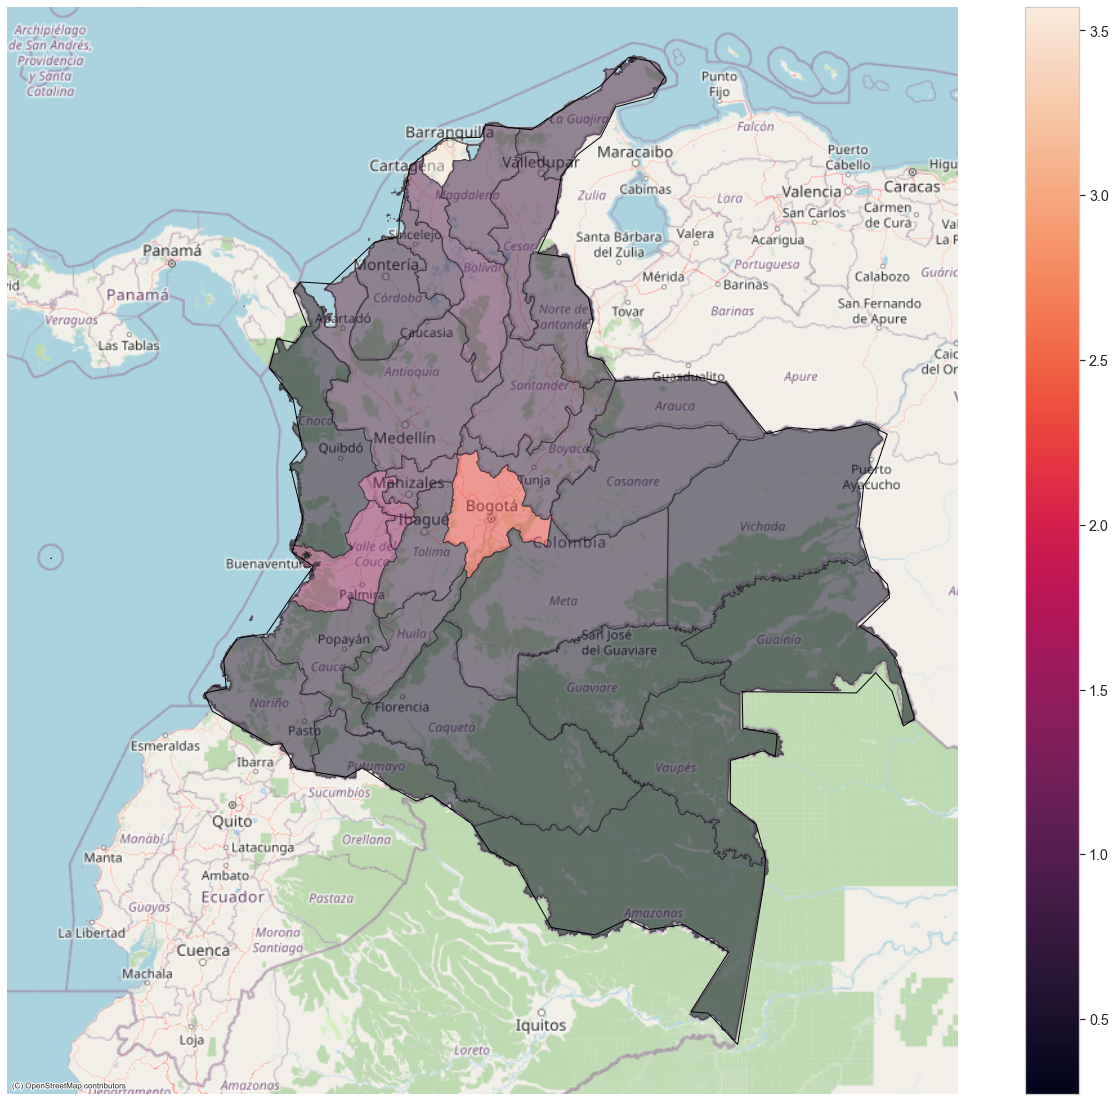

In [95]:
f, ax = plot_heatmap_geo(
    geo_plot_df, cntry_selected_abbr, statcol="mean", opacity=0.5, figsize=(24, 20)
)
f.savefig(
    PROJ
    / f"figs/{cntry_selected_abbr}_{vcm_type}_gadm_{selected_admin_level}_heatmap_{year_selected}.png",
    bbox_inches="tight",
)

## Exploration - city level

In [44]:
# Read GHS to check
gdf_mask = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
ghs = gpd.read_file(
    DATA / "intermediate/ghs/ghs.shp",
    mask=gdf_mask[gdf_mask.iso_a3 == cntry_selected_abbr],
)
ghs = ghs[ghs.iso == cntry_selected_abbr]
ghs.ghs_id = ghs.ghs_id.astype(int)
ghs.head()

,ghs_id,iso,country,uc_name,region,subregion,pop_2015,pop_2000,ntl_2015,timetocap,geometry
1,488,COL,Colombia,Ipiales,Latin America and the Caribbean,South America,113249.682495,87903.029358,18.091242,474.254223,"POLYGON ((-77.65220 0.84113, -77.63224 0.84113..."
2,492,COL,Colombia,Pasto,Latin America and the Caribbean,South America,401867.377319,347964.721680,34.719560,436.493180,"POLYGON ((-77.29896 1.23745, -77.25904 1.23745..."
3,495,COL,Colombia,La Hormiga,Latin America and the Caribbean,South America,52227.718262,30492.241333,4.512172,414.709929,"POLYGON ((-76.91006 0.43674, -76.90008 0.43674..."
4,497,COL,Colombia,El esfuerzo,Latin America and the Caribbean,South America,375392.960693,288253.034241,17.677062,249.266386,"POLYGON ((-77.00827 3.89132, -76.99828 3.89132..."
5,499,COL,Colombia,Orito,Latin America and the Caribbean,South America,53859.869751,32738.761108,9.387951,401.664705,"POLYGON ((-76.88208 0.67937, -76.87211 0.67937..."


In [45]:
def add_ghs_data(
    results_df,
    ghs,
    cols=[
        "iso",
        "country",
        "uc_name",
        "region",
        "subregion",
        "pop_2015",
        "pop_2000",
        "ntl_2015",
        "timetocap",
    ],
):
    # Add back GHS data
    results_df["ghs_id"] = pd.to_numeric(results_df["ghs_id"])
    results_df = results_df.merge(ghs[["ghs_id"] + cols], on="ghs_id")
    return results_df

In [46]:
results_df = pd.read_parquet(
    PROJ / f"tables/{vcm_type}_{cntry_selected_abbr}_ghs_thresholded.parquet"
)
# Assign names
results_df = add_ghs_data(results_df, ghs, cols=["uc_name"])
results_df.head()

,date,ghs_id,mean,sum,median,stdDev,count,min,max,uc_name
0,2014-01-01,488,12.611813,560.013936,12.983452,7.047405,66,0.876056,32.524792,Ipiales
1,2014-02-01,488,12.413441,551.205471,11.674677,6.384941,66,2.220170,33.315571,Ipiales
2,2014-03-01,488,15.004119,554.093282,12.186586,11.078547,55,1.027678,35.351067,Ipiales
3,2014-04-01,488,13.931634,618.619177,14.595066,7.003626,66,1.686416,27.763693,Ipiales
4,2014-05-01,488,15.460231,686.494894,16.651697,8.589042,66,1.450099,32.210835,Ipiales


In [47]:
# Prepare visualization data
def prep_viz_data(df, topn=5, selected_regions=None):
    # Select some regions
    if selected_regions is None:
        selected_regions = (
            df.groupby(["uc_name"])["sum"].sum().nlargest(topn).index.tolist()
        )
    # Filter data to selected
    df = df[df["uc_name"].isin(selected_regions)].copy()
    return df

In [48]:
viz_df = prep_viz_data(
    results_df,
    selected_regions=[
        "Bogota",
        "Barranquilla",
        "Cali",
        "Cartagena",
        "Florencia",
        "Medellín",
        "San José del Guaviare",
    ],
)
viz_df.head()

,date,ghs_id,mean,sum,median,stdDev,count,min,max,uc_name
612,2014-01-01,512,42.124497,28729.567953,38.758362,23.980826,757,3.164907,125.485291,Cali
613,2014-02-01,512,43.717247,29815.848150,44.241106,21.738665,757,4.379899,96.700302,Cali
614,2014-03-01,512,46.831346,31939.712502,48.520514,24.284771,757,3.344915,137.938538,Cali
615,2014-04-01,512,48.434679,26241.909268,45.735674,27.380821,605,1.725375,115.773094,Cali
616,2014-05-01,512,33.205187,22646.458352,32.232069,21.450003,757,0.000000,99.749725,Cali


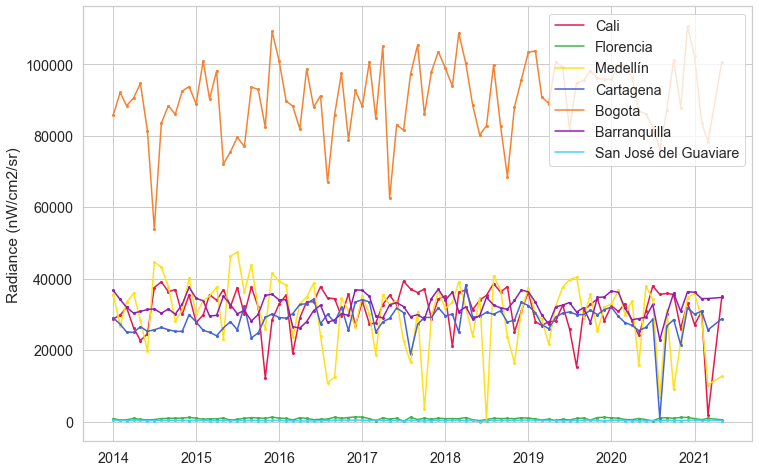

In [49]:
f, ax = plot_ntl_line(viz_df, stat="sum", hue="uc_name")
f.savefig(
    PROJ / f"figs/{cntry_selected_abbr}_{vcm_type}_ghs.png",
    bbox_inches="tight",
)

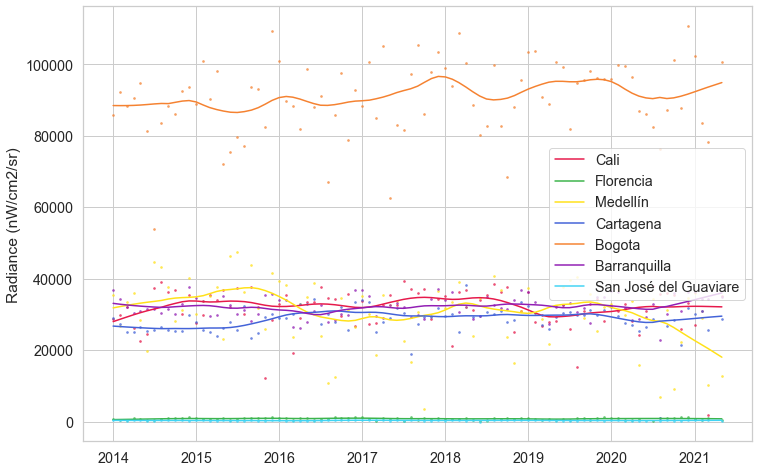

In [50]:
f, ax = plot_ntl_smoothed(viz_df, stat="sum", hue="uc_name")
f.savefig(
    PROJ / f"figs/{cntry_selected_abbr}_{vcm_type}_ghs_smoothed.png",
    bbox_inches="tight",
)

In [51]:
viz_df.head()

,date,ghs_id,mean,sum,median,stdDev,count,min,max,uc_name
612,2014-01-01,512,42.124497,28729.567953,38.758362,23.980826,757,3.164907,125.485291,Cali
613,2014-02-01,512,43.717247,29815.848150,44.241106,21.738665,757,4.379899,96.700302,Cali
614,2014-03-01,512,46.831346,31939.712502,48.520514,24.284771,757,3.344915,137.938538,Cali
615,2014-04-01,512,48.434679,26241.909268,45.735674,27.380821,605,1.725375,115.773094,Cali
616,2014-05-01,512,33.205187,22646.458352,32.232069,21.450003,757,0.000000,99.749725,Cali


### Admin boundaries

In [59]:
month = "2021-01-01"

In [60]:
# Prepare geoplot df
geo_plot_df = results_df[results_df.date == pd.to_datetime(month)].copy()
geo_plot_df["ghs_id"] = pd.to_numeric(geo_plot_df["ghs_id"])
geo_plot_df = ghs.merge(geo_plot_df.drop(columns="uc_name"), on="ghs_id")

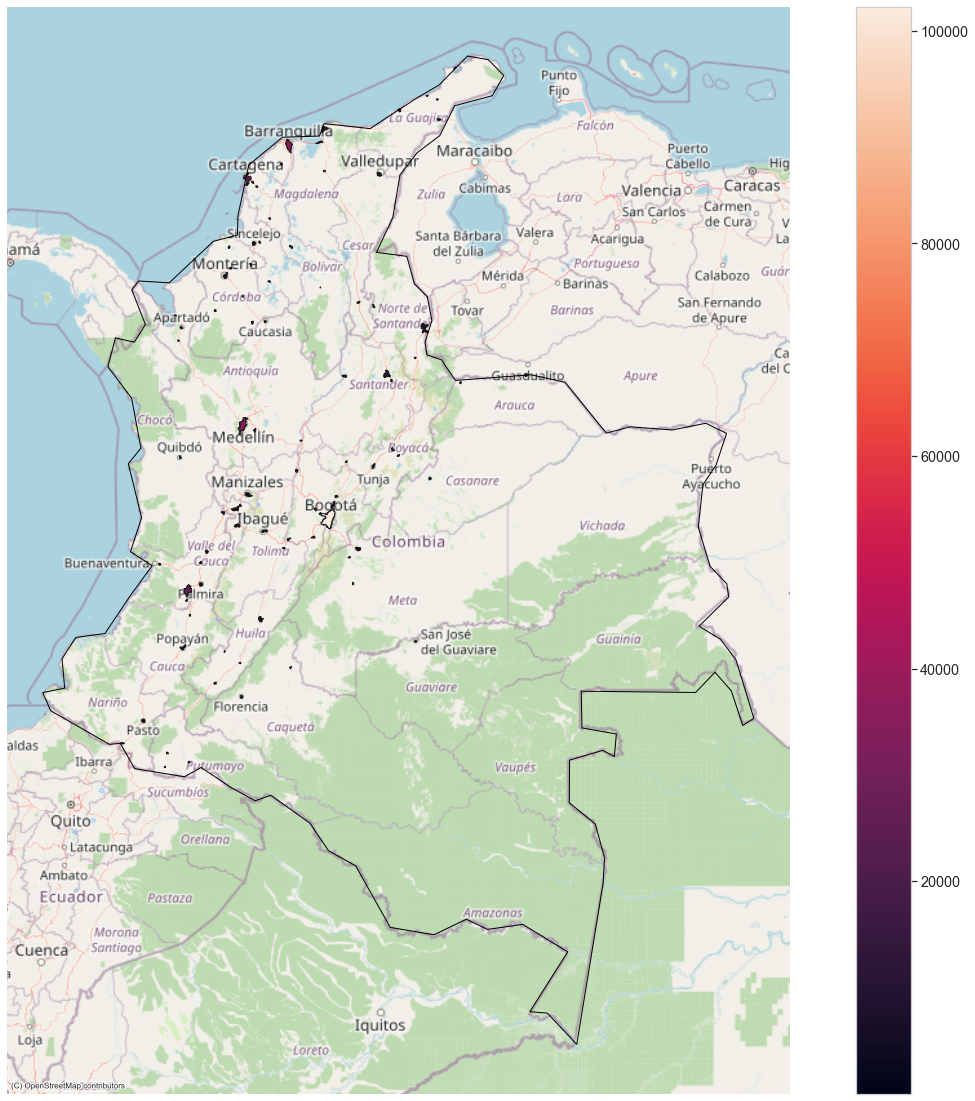

In [61]:
f, ax = plot_heatmap_geo(
    geo_plot_df, cntry_selected_abbr, statcol="sum", figsize=(24, 20)
)
f.savefig(
    PROJ / f"figs/{cntry_selected_abbr}_{vcm_type}_ghs_heatmap_{month}.png",
    bbox_inches="tight",
)